**Báo cáo cuối kỳ môn học: PYTHON CHO KHOA HỌC DỮ LIỆU**

**Lớp 23TTH, Khoa Toán - Tin học, Trường Đại học Khoa học Tự nhiên, ĐHQG-HCM**

**Đề tài thực hiện:**
$$
\text{\textbf{USING DEEP LEARNING TO CLASSIFY ANIMAL AND HUMAN IMAGES}}
$$

**Giảng viên hướng dẫn: ThS. Hà Văn Thảo**

**Danh sách thành viên nhóm:**

1. 23110114 - Nguyễn Thị Hồng Thắm \
2. 23110123 - Lê Huỳnh Yến Vy \
3. 23110132 - Trần Nhật Anh

# GIỚI THIỆU

Object detection là một trong những chủ đề "nóng" trong deep learing bởi tính ứng dụng cao trong thực tiễn và nguồn dữ liệu dồi dào, dễ chuẩn bị. Một trong những thuật toán object detection nổi tiếng nhất là **YOLO**.

YOLO là mô hình mạng neuron tích chập (CNN) được sử dụng phổ biển để nhận dạng các đối tượng trong ảnh hoặc video. Điểm đặc biệt của mô hình này là có khả năng phát hiện tất cả các đối tượng trong một hình ảnh chỉ qua một lần lan truyền của CNN.

Các phương pháp truyền thống tách biệt bước đề xuất vùng và bước phân loại, YOLO xử lý toàn bộ hình ảnh trong một lần lan truyền duy nhất qua mạng CNN. Cơ chế này cho phép mô hình vừa định vị (localization), vừa phân loại (classification) đối tượng cùng lúc.

YOLO có nghĩa là "You only look once", thuật toán chỉ cần "nhìn" một lần để có thể đưa ra dự đoán, giúp đạt được tốc độ xử lý cực nhanh, tiệm cận thời gian thực (real-time) mà vẫn đảm bảo độ chính xác cao. Vì vậy, YOLO được ứng dụng rộng rãi trong đa dạng lĩnh vực: từ quản lý giao thông thông minh, giám sát dây chuyền sản xuất, nông nghiệp công nghệ cao (đếm vật nuôi,...), cho đến các hệ thống an ninh giám sát (phát hiện vũ khí, chấm công tự động,...),...

# TẠO MÔI TRƯỜNG ẢO VÀ KERNEL CHẠY NOTEBOOK (LINUX)

Dự án Python cần **môi trường ảo (virtual environment)** để tự cách ly, tránh xung đột phiên bản thư viện giữa các dự án. `venv` là môi trường ảo mà chúng ta sẽ sử dụng trong dự án này. Sau khi cài đặt `venv`, chúng ta di chuyển đường dẫn đến folder chứa dự án trong terminal và sử dụng lệnh sau để cài đặt môi trường ảo cho dự án:

`python -m venv .venv`

Trong đó, `.venv` là tên của folder chứa môi trường ảo của dự án, đồng thời nó cũng sẽ "đóng băng" phiên bản Python, pip và các thư viện sẽ được dùng trong dự án.

Kích hoạt môi trường ảo:

`source .venv/bin/activate`

Lúc này, phiên bản Python và `pip` được dùng là của môi trường ảo, các thư viện cài bằng `pip install` cũng chỉ ảnh hưởng trong `.venv`. Cách nhận biết đang ở môi trường ảo là promt terminal thường đổi thành `(.venv) user_name@machine:~` (nếu đang sử dụng Linux). Khi đã kích hoạt môi trường ảo, đảm bảo phiên bản Python và `pip` đã "đóng băng" trong đó, sử dụng lệnh:

`which python && which pip`

Nếu output có dạng `.../<project_name>/.venv/...` thì môi trường ảo đã được kích hoạt thành công.

Tiếp theo, tạo một kernel để chạy Jupyter Notebook. Cài đặt `ipykernel` để tạo kernel:

`python -m pip install ipykernel`

Sau khi cài đặt thành công, tiến hành tạo kernel để chạy file `.ipynb`:

`python -m ipykernel install --prefix .venv --name yolovenv --display-name "this_project"`

`--prefix .venv`: kernel mặc định không tự lưu vào `.venv`, thuộc tính này sẽ lưu kernel đã tạo vào `.venv`  
`--name yolovenv`: tên folder chứa kernel, ở đây tên folder là `yolovenv`. Kernel sẽ được lưu tại `.venv/share/jupyter/kernels/yolovenv/`  
`--display-name "this_project"`: kernel sẽ hiển thị dưới tên `this_project` trong VS Code.

Khi đã tạo kernel, click vào biểu tượng kernel ở góc trên bên phải, chọn
$$
\text{Select Another Kernel} \rightarrow \text{Jupyter Kernel...} \rightarrow \text{this\_project}
$$

# CÁC THƯ VIỆN CẦN DÙNG

In [1]:
from collections import Counter, defaultdict
from itertools import product
import os
from pathlib import Path

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ultralytics import YOLO
import yaml

# CHUẨN BỊ VÀ TỔNG QUAN VỀ DỮ LIỆU

## CHUẨN BỊ DỮ LIỆU

Dữ liệu được tải về tại các nguồn sau: \
- https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset \
- https://www.kaggle.com/datasets/biancaferreira/african-wildlife \
- https://www.kaggle.com/datasets/wutheringwang/dog-face-detectionyolo-format \
- https://www.kaggle.com/datasets/samuelayman/cat-dataset \
- https://universe.roboflow.com/labo-yolo/age-and-gender-xlnfj/dataset/3

Dữ liệu sau khi được tải về sẽ được xử lý (gán lại class ID; phân loại thành các folder train, valid, test;...), sau đó được gộp thành một folder tập dữ liệu (dataset) duy nhất. Dataset nếu muốn được YOLO "hiểu" thì phải có file `.yaml` chứa các thông tin về dataset như vị trí của file train, valid, test; số class; tên của các class ứng với mỗi class_id;...

Dataset của dự án này nằm tại `dataset/complete_dataset`, bao gồm: \
- folder `images` chứa các file ảnh, được chia thành ba folder train, valid, test. \
- folder `labels` chứa các file **nhãn dữ liệu (label)** có đuôi `.txt`, cũng được chia thành ba folder train, valid, test và các file label có tên ứng với các file ảnh. \
- file `.yaml` để cung cấp thông tin về dataset cho YOLO.

In [2]:
DATASET_PATH = "dataset/complete_dataset/data.yaml"
BASE_DIR = Path("dataset/complete_dataset")
IMAGES_DIR = "dataset/complete_dataset/images"
LABELS_DIR = "dataset/complete_dataset/labels"

IMAGE_EXTS = [".jpg", ".png", ".jpeg", ".webp"]

## LÀM SẠCH VÀ CHUẨN HOÁ DỮ LIỆU

Dữ liệu hình ảnh được tổng hợp từ nhiều nguồn khác nhau thường tìm ẩn các vấn đề về tính toàn vẹn, chẳng hạn như sự không đồng nhất về định dạng (PNG, JPG, WEBP...), lỗi header của file ảnh hoặc file bị hỏng hoàn toàn (corrupt). Những vấn đề này có thể gây ra lỗi ngắt quãng (crash) đột ngột cho thư viện huấn luyện (như PyTorch/YOLO) khi mô hình cố gắng đọc dữ liệu, làm gián đoạn quá trình huấn luyện kéo dài.

Để khắc phục, cần làm sạch và chuẩn hóa dataset thông qua hàm `resave_images` để:
- Chuẩn hóa định dạng: Mở từng file ảnh, chuyển đổi hệ màu về RGB và lưu lại (re-save) dưới định dạng JPEG để đảm bảo tính nhất quán. \
- Xử lý lỗi tự động: Nếu phát hiện file ảnh bị lỗi không thể đọc được (corrupt), tự động xóa file ảnh đó, đồng thời xóa luôn file nhãn (label) tương ứng để tránh dư thừa label. \
- Tối ưu hóa quy trình: Để tránh việc phải xử lý lại toàn bộ dữ liệu (tốn nhiều thời gian) mỗi khi chạy lại file Jupyter Notebook, cần tạo một cơ chế đánh dấu bằng việc kiểm tra liệu có tồn tại file `flag_file.txt` trong folder chứa dataset. Quá trình chuẩn hóa chỉ được thực hiện nếu file này chưa tồn tại.

Kiểm tra xem dataset đã từng được xử lý chưa thông qua hàm `check_flag_file`.

In [3]:
def check_flag_file(BASE_DIR):
    flag_file = BASE_DIR / "flag_file.txt"

    if not flag_file.exists():
        return False
    
    with open(flag_file, 'r') as file:
        return file.read().strip() == "This dataset has been re-saved already."

Hàm `create_flag_file` dùng để tạo flag file.

In [4]:
def create_flag_file(BASE_DIR):
    if check_flag_file(BASE_DIR):
        return
    
    flag_file = BASE_DIR / "flag_file.txt"
    content = "This dataset has been re-saved already."

    with open(flag_file, 'w') as file:
        file.write(content)

Thực hiện chuẩn hóa và loại bỏ ảnh lỗi. Hàm `resave` sẽ duyệt qua toàn bộ thư mục, thực hiện việc xác thực (verify) và lưu lại ảnh. Những ảnh bị lỗi Exception sẽ bị xóa cùng với file label của chúng.

In [5]:
def resave(IMAGES_DIR, LABELS_DIR):
    fixed = 0
    removed = 0

    for root, _, files in os.walk(IMAGES_DIR):
        for f in files:
            if not f.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                continue

            # Ghép IMAGES_DIR với tên file ảnh thành path file ảnh
            image_path = os.path.join(root, f)

            try:
                # Mở ảnh để verify nhanh, nếu ảnh có vấn đề -> exception
                with Image.open(image_path) as image:
                    image.verify()

                # Mở lại để re-save
                with Image.open(image_path) as image:
                    image = image.convert("RGB")
                    image.save(image_path, "JPEG", quality=95, subsampling=0)

                fixed += 1

            except Exception:
                # Nếu ảnh hỏng -> xoá file ảnh cùng với file label tương ứng
                os.remove(image_path)
                removed += 1

                relative_path = os.path.relpath(root, IMAGES_DIR)

                label_path = os.path.join(
                    LABELS_DIR,
                    relative_path,
                    os.path.splitext(f)[0] + ".txt"
                )

                if os.path.exists(label_path):
                    os.remove(label_path)

    return fixed, removed

Hàm `resave_images` điều phối quá trình và thông báo số lượng ảnh đã sửa hoặc đã xóa.

In [6]:
def resave_images(BASE_DIR, IMAGES_DIR, LABELS_DIR):
    if check_flag_file(BASE_DIR):
        return 0, 0
    else:
        fixed, removed = resave(IMAGES_DIR, LABELS_DIR)
        create_flag_file(BASE_DIR)

        return fixed, removed

In [7]:
fixed, removed = resave_images(BASE_DIR, IMAGES_DIR, LABELS_DIR)

print("Fixed  :", fixed)
print("Removed:", removed)

Fixed  : 0
Removed: 0


## XOÁ CÁC CLASS CÓ DƯỚI 100 OBJECT

In [8]:
SUB_FOLDERS = ["train", "valid", "test"]
IMAGES_DIRS = {folder: BASE_DIR / f"images/{folder}" for folder in SUB_FOLDERS}
LABELS_DIRS = {folder: BASE_DIR / f"labels/{folder}" for folder in SUB_FOLDERS}

MIN_OBJECTS = 100

# Đếm object từng class (file train)
class_counts = defaultdict(int)

train_label_cache = {}

for label_path in LABELS_DIRS["train"].glob("*.txt"):
    with open(label_path, "r") as f:
        lines = [l.strip() for l in f if l.strip()]

    train_label_cache[label_path] = lines

    for line in lines:
        class_id = int(line.split()[0])
        class_counts[class_id] += 1

print("Object count per class (train):")
for cid in sorted(class_counts):
    print(f"Class {cid}: {class_counts[cid]}")


# Chọn class được giữ lại / xoá (xoá các class có dưới 100 object)
kept_classes = sorted(
    cid for cid, cnt in class_counts.items() if cnt >= MIN_OBJECTS
)
removed_classes = sorted(
    cid for cid, cnt in class_counts.items() if cnt < MIN_OBJECTS
)

print("\n")
print("Kept classes:", kept_classes)
print("Removed classes:", removed_classes)

old_to_new = {old: new for new, old in enumerate(kept_classes)}


# Xoá file ảnh cùng file label tương ứng
removed_labels = {folder: 0 for folder in SUB_FOLDERS}
removed_images = {folder: 0 for folder in SUB_FOLDERS}

for folder in SUB_FOLDERS:
    for label_path in LABELS_DIRS[folder].glob("*.txt"):
        with open(label_path, "r") as f:
            lines = [l.strip() for l in f if l.strip()]

        new_lines = []

        for line in lines:
            parts = line.split()
            old_class = int(parts[0])

            if old_class in old_to_new:
                parts[0] = str(old_to_new[old_class])
                new_lines.append(" ".join(parts))

        if not new_lines:
            # Xoá label
            label_path.unlink()
            removed_labels[folder] += 1

            # Xoá ảnh tương ứng
            for ext in IMAGE_EXTS:
                img_path = IMAGES_DIRS[folder] / (label_path.stem + ext)
                if img_path.exists():
                    img_path.unlink()
                    removed_images[folder] += 1
                    break
        else:
            with open(label_path, 'w') as f:
                f.write("\n".join(new_lines) + "\n")


print("\n")
print("Removed files:")
for folder in SUB_FOLDERS:
    print(
        f"{folder}: "
        f"{removed_labels[folder]} labels, "
        f"{removed_images[folder]} images"
    )


# Sửa file data.yaml
with open(DATASET_PATH, "r") as f:
    data_yaml = yaml.safe_load(f)

old_names = data_yaml["names"]
new_names = [old_names[cid] for cid in kept_classes]

data_yaml["nc"] = len(new_names)
data_yaml["names"] = new_names

with open(DATASET_PATH, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("\n")
print("data.yaml updated")
print("New nc:", data_yaml["nc"])

Object count per class (train):
Class 0: 1820
Class 1: 309
Class 2: 118
Class 3: 271
Class 4: 207
Class 5: 261
Class 6: 536
Class 7: 488
Class 8: 598
Class 9: 1067
Class 10: 102
Class 11: 388
Class 12: 225
Class 13: 145
Class 14: 102
Class 15: 229
Class 16: 323
Class 17: 528
Class 18: 257
Class 19: 135
Class 20: 796
Class 21: 537
Class 22: 100
Class 23: 277
Class 24: 355
Class 25: 917
Class 26: 146
Class 27: 149
Class 28: 500
Class 29: 221
Class 30: 257
Class 31: 378
Class 32: 342
Class 33: 574
Class 34: 246
Class 35: 168
Class 36: 190
Class 37: 222
Class 38: 291
Class 39: 224
Class 40: 116
Class 41: 106
Class 42: 644
Class 43: 354
Class 44: 387
Class 45: 321
Class 46: 4250
Class 47: 892


Kept classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Removed classes: []


Removed files:
train: 0 labels, 0 images
valid: 0 labels, 0 images
test: 0 labels,

## KIỂM TRA FILE LABEL TƯƠNG ỨNG VỚI FILE ẢNH

Sau khi hoàn tất xử lý dataset, dùng hàm `count_missing` để kiểm tra xem với mỗi file ảnh thì có file label tương ứng hay không. Cần đảm bảo 100% ảnh đầu vào đều có nhãn tương ứng (0% missing labels).

Sau bước làm sạch và chuẩn hoá dataset, tiến hành kiểm tra tính toàn vẹn của dữ liệu thông qua hàm `count_missing`. Mục tiêu của bước này là rà soát đối sánh từng file ảnh với file label tương ứng trong các thư mục con (train, valid, test) để đảm bảo rằng mọi dữ liệu đưa vào mô hình đều hợp lệ và đầy đủ thông tin.

Hàm `count_missing` được xây dựng để duyệt qua từng file ảnh và kiểm tra sự tồn tại của file label `.txt` tương ứng. Cần đảm bảo toàn bộ ảnh đều có file label (0% missing labels).

In [9]:
def count_missing(BASE_DIR, image_exts, sub_folder):
    images_dir = BASE_DIR / "images" / sub_folder
    labels_dir = BASE_DIR / "labels" / sub_folder

    images_cnt = 0
    missing_cnt = 0

    for image in images_dir.iterdir():
        if image.suffix.lower() not in image_exts:
            continue

        images_cnt += 1
        """
        image.stem dùng để lấy tên của file image mà không có phần mở rộng
        Ví dụ: example123.png -> example123
        """
        label_file = labels_dir / f"{image.stem}.txt"
        if not label_file.exists():
            missing_cnt += 1

    return images_cnt, missing_cnt

Tiến hành chạy kiểm tra trên toàn bộ dataset và tổng hợp kết quả vào bảng để dễ dàng quan sát tỷ lệ lỗi.

In [10]:
image_exts = {".jpg", ".jpeg", ".png", ".webp"}
sub_folders = ["train", "valid", "test"]

print(f"Checking dataset: {str(BASE_DIR)}\n")

total_images = 0
total_missing = 0
images_cnt_arr = np.array([])
missing_cnt_arr = np.array([])
missing_percent_arr = np.array([])

for sub_folder in sub_folders:
    images_cnt, missing_cnt = count_missing(BASE_DIR, image_exts, sub_folder)
    total_images += images_cnt
    total_missing += missing_cnt

    missing_percent = (missing_cnt / images_cnt) * 100 if images_cnt > 0 else 0

    images_cnt_arr = np.append(images_cnt_arr, images_cnt)
    missing_cnt_arr = np.append(missing_cnt_arr, missing_cnt)
    missing_percent_arr = np.append(missing_percent_arr, missing_percent)

images_percent = np.array([(images_cnt / total_images) * 100 \
                           for images_cnt in images_cnt_arr])

np_table = np.array([images_cnt_arr, images_percent, \
                     missing_cnt_arr, missing_percent_arr])
table = pd.DataFrame(np_table).transpose()
table.columns = ["images", "images/total (%)", 
                 "missing_labels", "missing_labels (%)"]
table.index = ["train", "valid", "test"]
table['images'] = table['images'].astype(int)
table['missing_labels'] = table['missing_labels'].astype(int)

if total_images > 0:
    missing_percent = (total_missing / total_images) * 100
else:
    missing_percent = 0

print(table)
print("")
print(f"-> Total images:       {total_images}")
print(f"-> Total missing:      {total_missing}")
print(f"-> Total missing (%):  {missing_percent}")

Checking dataset: dataset/complete_dataset

       images  images/total (%)  missing_labels  missing_labels (%)
train   17579         65.831555               0                 0.0
valid    5131         19.215069               0                 0.0
test     3993         14.953376               0                 0.0

-> Total images:       26703
-> Total missing:      0
-> Total missing (%):  0.0


Kết quả cho thấy toàn bộ 26703 ảnh đều có đủ file label tương ứng (`Total missing: 0`), dữ liệu đảm bảo điều kiện để huấn luyện mô hình.

## PHÂN BỐ CÁC CLASS

Việc thống kê số object của mỗi class nhằm xác định mức độ mất cân bằng dữ liệu giữa 48 class của dataset, nhận diện lớp chiếm ưu thế và các lớp thiểu số hoặc các lớp rỗng để lường trước những nhược điểm, hạn chế của mô hình.

In [11]:
CLASS_NUM = 48

Ngoài ra cũng có thể có nhiều object trong mỗi ảnh nên tổng số object luôn nhiều hơn hoặc bằng số ảnh. Cụ thể, dataset này có tổng cộng 33842 object so với 26703 ảnh.

In [12]:
LABELS_DIR = BASE_DIR / "labels"

counter = Counter()

for label_file in LABELS_DIR.rglob("*.txt"):
    with open(label_file, "r") as file:
        for line in file:
            if line.strip():
                class_id = int(line.split()[0])
                counter[class_id] += 1

df = pd.DataFrame(
    sorted(counter.items()),
    columns=["class_id", "object_count"]
)

df = df.sort_values("object_count", ascending=False, ignore_index=True)
total_objects = df["object_count"].sum()
df["object_count (%)"] = (df["object_count"] * 100 / total_objects).round(5)
print(f"Total objects: {total_objects}")

Total objects: 33842


Phân bố số object của mỗi class.

In [13]:
# Sắp xếp df theo thứ tự giảm dần của cột object_count rồi lấy 15 dòng đầu tiên
df_top15 = df.sort_values(by="object_count", 
                          ascending=False, 
                          ignore_index=True).head(15)

df_top15

,class_id,object_count,object_count (%)
0,46,6340,18.73412
1,0,2774,8.19692
2,9,1647,4.86673
3,25,1603,4.73672
4,20,1246,3.68182
5,47,1188,3.51043
6,42,1021,3.01696
7,33,915,2.70374
8,8,913,2.69783
9,6,864,2.55304


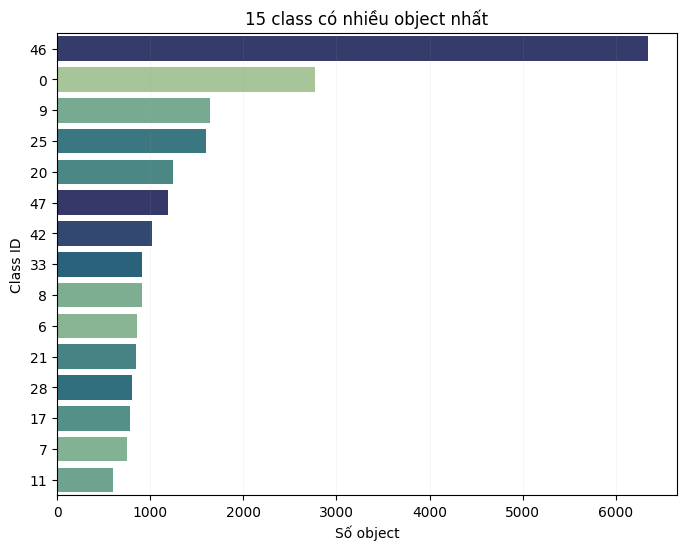

In [14]:
plt.figure(figsize=(8, 6))

order = (
    df_top15
    .sort_values("object_count", ascending=False)["class_id"]
    .astype(str)
)

sns.barplot(
    data=df_top15,
    x="object_count",
    y=df_top15["class_id"].astype(str),
    order=order,
    hue="class_id",
    palette="crest",
    legend=False,
    errorbar=None
)

plt.xlabel("Số object")
plt.ylabel("Class ID")
plt.title("15 class có nhiều object nhất")
plt.grid(axis='x', alpha=0.1)
plt.show()


In [15]:
# Sắp xếp df theo thứ tự tăng dần của cột object_count rồi lấy 15 dòng đầu tiên
df_bottom15 = df.sort_values(by="object_count", 
                             ascending=True, 
                             ignore_index=True).head(15)

df_bottom15

,class_id,object_count,object_count (%)
0,22,149,0.44028
1,10,150,0.44324
2,41,154,0.45506
3,14,160,0.47279
4,40,176,0.52006
5,2,178,0.52597
6,19,214,0.63235
7,13,219,0.64712
8,27,220,0.65008
9,26,234,0.69145


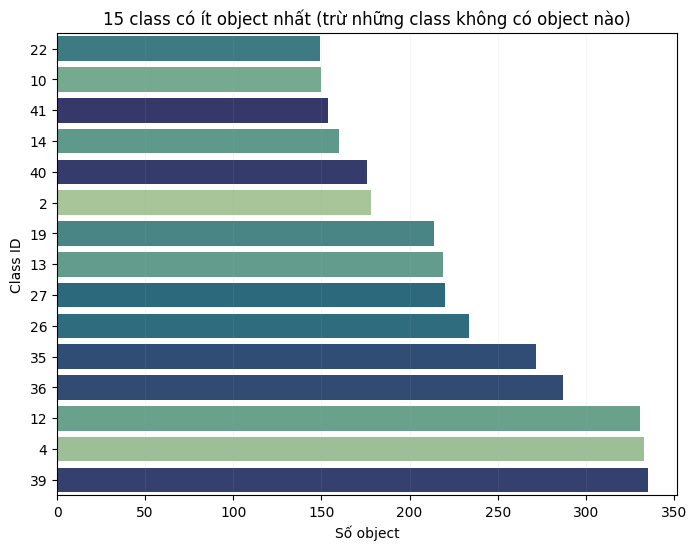

In [16]:
plt.figure(figsize=(8, 6))

order = (
    df_bottom15
    .sort_values("object_count", ascending=True)["class_id"]
    .astype(str)
)

sns.barplot(
    data=df_bottom15,
    x="object_count",
    y=df_bottom15["class_id"].astype(str),
    order=order,
    hue="class_id",
    palette="crest",
    legend=False,
    errorbar=None
)

plt.xlabel("Số object")
plt.ylabel("Class ID")
plt.title("15 class có ít object nhất (trừ những class không có object nào)")
plt.grid(axis='x', alpha=0.1)
plt.show()


Phân bố số lượng đối tượng (object) giữa các class là không đồng đều. Từ hai biểu đồ trên, có thể thấy sự mất cân bằng nghiêm trọng giữa các class. Cụ thể:
- Class có ID 83 chiếm số lượng áp đảo với 6340 objects (khoảng 18.73%), gấp hơn 2 lần so với class đứng thứ hai là 0 (2774 đối tượng, chiếm khoảng 8.2%).
- Ngược lại, có những class có rất ít object như 2, 40, 14, 41, 10, 22,... có dưới 200 object.

Điều này sẽ khiến mô hình có xu hướng học thiên lệch (bias), nhận diện tốt các class có nhiều object nhưng dễ bỏ qua các class chiếm thiểu số, `recall` (độ nhạy) thấp cho các class thiểu số, `precision` (độ chính xác) có vẻ cao nhưng `mAP` giữa các class không đồng đều,...

Sự mất cân bằng nghiêm trọng về số lượng mẫu giữa các lớp (class imbalance) tạo ra rào cản lớn cho quá trình tối ưu hóa: hàm mất mát (loss function) sẽ bị chi phối bởi các lớp đa số, khiến mạng neuron có xu hướng học thiên lệch (bias) để giảm thiểu sai số cục bộ. Hệ quả là mô hình có thể đạt độ chính xác tổng thể cao nhờ đoán đúng các lớp phổ biến, nhưng lại thất bại hoặc có `recall` rất thấp khi nhận diện các lớp thiểu số do không đủ dữ liệu để học các đặc trưng tổng quát.

## PHÂN BỐ KÍCH THƯỚC ẢNH

Bên cạnh vấn đề mất cân bằng về số lượng object giữa các class (như đã phân tích ở trên) thì độ phân giải hình ảnh (image resolution) cũng là một yếu tố then chốt ảnh hưởng đến hiệu năng của mô hình. Do bộ dữ liệu được tổng hợp từ nhiều nguồn khác nhau (Kaggle, Roboflow...), sự không đồng nhất về kích thước ảnh (chiều rộng và chiều cao) là điều không thể tránh khỏi.

Vì vậy, cần thực hiện phân tích thống kê chiều rộng và chiều cao của ảnh thuộc file train. Kết quả phân bố này là cơ sở thực tiễn để chúng ta đưa ra quyết định lựa chọn `imgsz` phù hợp nhất cho các thực nghiệm ở phần sau.

In [17]:
# Chỉ cần kiểm tra phân bố kích thước ảnh của file train
TRAIN_IMAGES_DIR = Path("dataset/complete_dataset/images/train")

widths = np.array([])
heights = np.array([])

image_paths = [
    p for p in TRAIN_IMAGES_DIR.iterdir()
    if p.suffix.lower() in {".jpg", ".png", ".jpeg", ".webp"}
]

for image_path in image_paths:
    image = cv2.imread(str(image_path))
    if image is None:
        continue

    height, width, _ = image.shape
    widths = np.append(widths, width)
    heights = np.append(heights, height)

Biểu đồ phân bố kích thước ảnh.

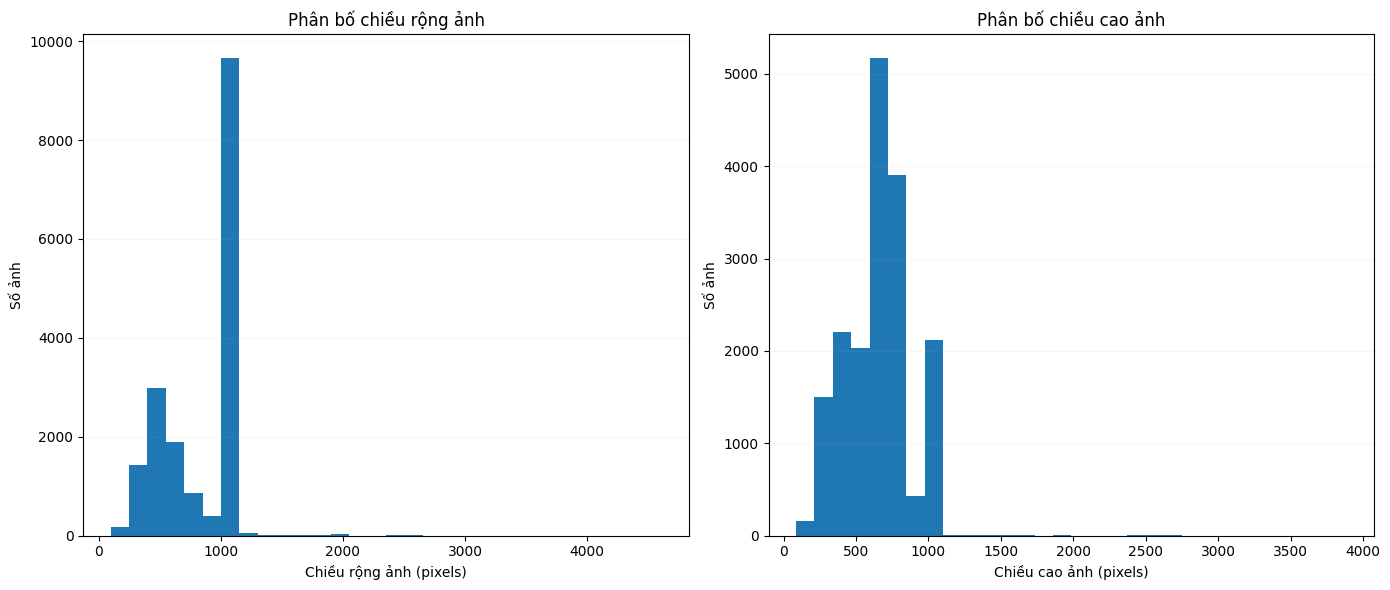

In [18]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30)
plt.xlabel("Chiều rộng ảnh (pixels)")
plt.ylabel("Số ảnh")
plt.title("Phân bố chiều rộng ảnh")
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30)
plt.xlabel("Chiều cao ảnh (pixels)")
plt.ylabel("Số ảnh")
plt.title("Phân bố chiều cao ảnh")
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()

plt.show()

Quan sát biểu đồ tần suất (histogram) của chiều rộng ảnh, ta thấy sự tập trung mật độ cao nhất nằm ở khoảng 1000 pixels. Tuy nhiên, phổ kích thước trải rất rộng, xuất hiện cả những ảnh có chiều ngang rất nhỏ (dưới 500 pixels) và cực lớn (lên tới 4000 pixels).

Tương tự, chiều cao của ảnh cũng không đồng nhất. Đa số các ảnh có chiều cao tập trung trong khoảng 600 đến 800 pixels (thể hiện qua cột cao nhất trên biểu đồ). Bên cạnh đó, vẫn tồn tại một lượng đáng kể các ảnh có chiều cao vượt trội (trên 2000 - 3000 pixels) hoặc rất thấp.

Các biểu đồ phân bố trên đã chỉ ra sự không đồng nhất lớn về kích thước của các ảnh dữ liệu đầu vào, với độ phân giải trải dài từ thấp đến cao. Điều này sẽ ảnh hưởng đến việc lựa chọn `imgsz` phù hợp trong khi huấn luyện mô hình. Mặc dù `imgsz` cao giúp bảo toàn thông tin chi tiết của ảnh gốc, nâng cao hiệu quả nhận diện, đặc biệt là với những ảnh có object nhỏ. Tuy nhiên, đổi lại là thời gian và tài nguyên tính toán.

## PHÂN BỐ BOUNDING BOX

In [19]:
TRAIN_LABELS_DIR = Path("dataset/complete_dataset/labels/train")

bbox_widths = np.array([])
bbox_heights = np.array([])
bbox_areas = np.array([])

label_paths = [
    p for p in TRAIN_LABELS_DIR.iterdir()
    if p.suffix == ".txt"
]

for label_path in label_paths:
    with open(label_path, 'r') as label:
        lines = label.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        _, x_center, y_center, width, height = map(float, parts)

        bbox_widths = np.append(bbox_widths, width)
        bbox_heights = np.append(bbox_heights, height)
        bbox_areas = np.append(bbox_areas, width * height)

print(f"Total bounding boxes: {len(bbox_areas)}")
print(f"Mean bbox width     : {bbox_widths.mean():.4f}")
print(f"Mean bbox height    : {bbox_heights.mean():.4f}")
print(f"Mean bbox area      : {bbox_areas.mean():.4f}")

Total bounding boxes: 22069
Mean bbox width     : 0.4623
Mean bbox height    : 0.5053
Mean bbox area      : 0.2919


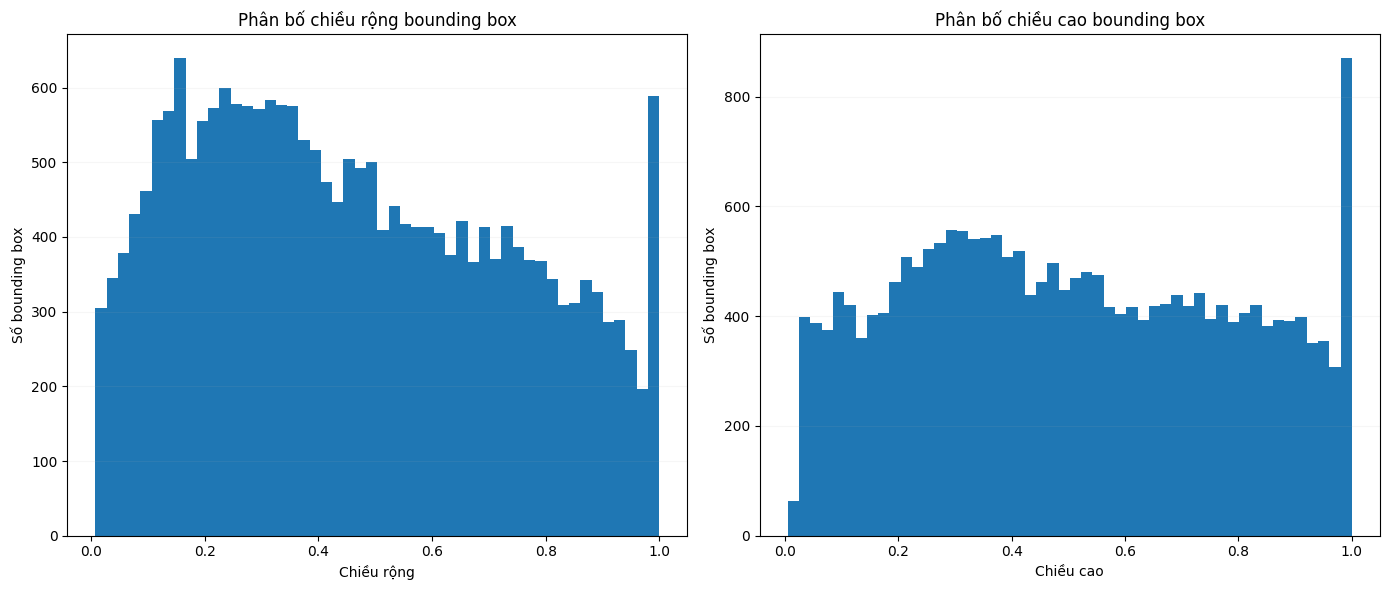

In [20]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(bbox_widths, bins=50)
plt.title("Phân bố chiều rộng bounding box")
plt.xlabel("Chiều rộng")
plt.ylabel("Số bounding box")
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(bbox_heights, bins=50)
plt.title("Phân bố chiều cao bounding box")
plt.xlabel("Chiều cao")
plt.ylabel("Số bounding box")
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()

plt.show()

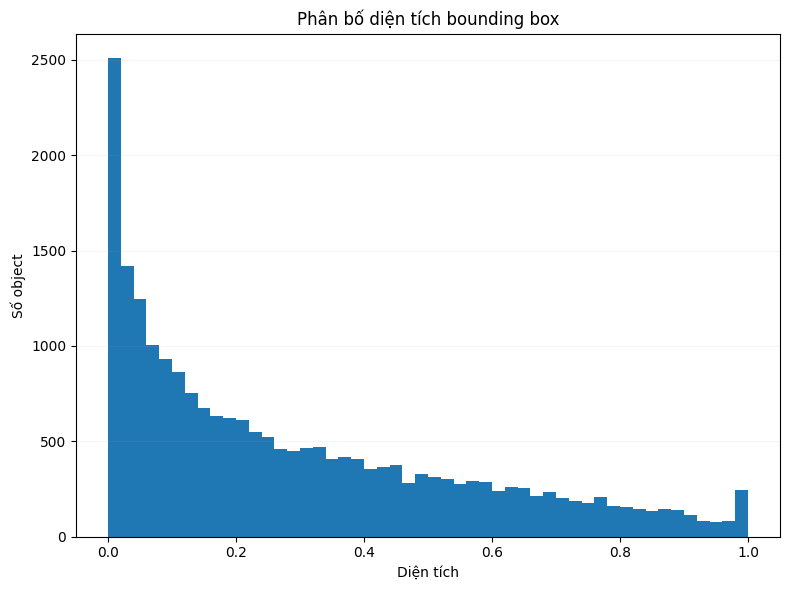

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(bbox_areas, bins=50)
plt.title("Phân bố diện tích bounding box")
plt.xlabel("Diện tích")
plt.ylabel("Số object")
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()

Phân bố bounding box cho thấy ở các cột bên trái của mỗi biểu đồ thường cao hơn, nghĩa là có nhiều object có kích thước nhỏ. Nhưng nhìn chung, kích thước của object trải dài rất nhỏ đến rất lớn so với toàn bộ ảnh, thể hiện qua số object tập trung nhiều ở vùng kích thước nhỏ.

Vì vậy, việc sử dụng kích thước ảnh đầu vào lớn hơn `imgsz=640` có thể giúp mô hình học được đặc trưng tốt hơn cho các object nhỏ, trong khi `imgsz=448` vẫn được thử nghiệm để đánh giá sự cân bằng giữa độ chính xác và chi phí tính toán.

# KHAI BÁO, HUẤN LUYỆN VÀ LƯU MÔ HÌNH

Phiên bản các thư viện dùng để huấn luyện mô hình: \
- Ultralytics 8.3.243 \
- Python-3.12.8 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX A6000, 48541MiB)

Mô hình sẽ được huấn luyện với hai hàm `train_model_with_SGD` và `train_model_with_AdamW`. Hàm `train_model_with_AdamW` có thêm các tham số tối ưu hoá, huấn luyện mô hình để cho ra các kết quả dùng để so sánh ở các phần sau.

Optimizer mặc định của YOLO11s/YOLO11m là `SGD`, mô hình sẽ được huấn luyện để so sánh với optimizer `AdamW`.

Ngoài ra, dùng `seed=42` là giá trị hạt giống ngẫu nhiên (`random seed`), dùng để cố định tính ngẫu nhiên trong quá trình huấn luyện. Giữa các lần chạy hàm `train`, cách chia dữ liệu train/val, thứ tự ảnh huấn luyện, trọng số ban đầu,... sẽ giống nhau. Điều này nhằm đảm bảo công bằng khi so sánh nhiều mô hình, nhiều tổ hợp tham số khác nhau. Tuy nhiên, không có công bằng "tuyệt đối" vì có tồn tại thứ tự tính toán khác nhau, sai số ở một vài chữ số thập phân,...

In [22]:
def train_model_with_SGD(model, epochs, imgsz, dataset_path, project_path, 
                         project_name):
    model.train(
        exist_ok=True,
        data=dataset_path,
        project=project_path,
        name=project_name,

        epochs=epochs,
        imgsz=imgsz,
        batch=32,
        workers=12,
        seed=42,
        device=0,  # sử dụng GPU

        cos_lr=True,

        mosaic=0.1,
        mixup=0.0,
        copy_paste=0.0,

        optimizer="SGD",
        lr0=0.01,
        momentum=0.937,
        weight_decay=5e-4,
    )


def train_model_with_AdamW(model, epochs, imgsz, dataset_path, project_path, 
                           project_name):
    model.train(
        exist_ok=True,
        data=dataset_path,
        project=project_path,
        name=project_name,

        epochs=epochs,
        imgsz=imgsz,
        batch=32,
        workers=12,
        seed=42,
        device=0,  # sử dụng GPU

        cos_lr=True,

        mosaic=0.1,
        mixup=0.0,
        copy_paste=0.0,

        optimizer="AdamW",
        lr0=0.001,
        weight_decay=1e-2,
    )

Thay vì chọn một cấu hình ngẫu nhiên, áp dụng phương pháp tìm kiếm lưới để xác định kiến trúc tối ưu nhất: \
- So sánh kiến trúc mạng: Đánh giá hiệu năng giữa YOLO11s (Small - tối ưu tốc độ) và YOLO11m (Medium - cân bằng độ chính xác). \
- Khảo sát siêu tham số: huấn luyện 16 mô hình với 16 tổ hợp tham số: số vòng lặp (`epochs`); kích thước ảnh (`imgsz`); thuật toán tối ưu (`optimizer`): So sánh giữa `SGD` (truyền thống) và `AdamW` (hiện đại) xem thuật toán nào hội tụ tốt hơn, cho ra kết quả tốt hơn.

In [23]:
BASE_MODELS = ["yolo11s", "yolo11m"]

epochs_list = [30, 80]
imgsz_list = [448, 640]
optimizer_list = ["SGD", "AdamW"]

# Huấn luyện mô hình với các thông số khác nhau
parameters = list(product(epochs_list, imgsz_list, optimizer_list))

Huấn luyện mô hình với các tham số khác nhau dựa trên YOLO11s và YOLO11m.

In [24]:
for base_model in BASE_MODELS:
    for parameter in parameters:
        epochs, imgsz, optimizer = parameter

        # Lưu model tại "runs/{...}/epochs{...}_imgsz{...}_{...}" sau khi train
        best_path = (
            Path(f"runs/{base_model}")
            / f"epochs{epochs}_imgsz{imgsz}_{optimizer}"
            / "weights"
            / "best.pt"
        )
        model_path = f"runs/{base_model}"
        model_name = f"epochs{epochs}_imgsz{imgsz}_{optimizer}"

        # Huấn luyện mô hình với dataset
        if best_path.exists():
            print(str(best_path))
            print(
                f"Model has been trained already. It is being loaded again..."
            )
            model = YOLO(str(best_path))
        else:
            print(str(best_path))
            print("Model hasn't been trained. Start training...")

            # Huấn luyện mô hình dựa trên mô hình gốc
            model = YOLO(base_model)
            if optimizer == "AdamW":
                train_model_with_AdamW(
                    model=model,
                    epochs=epochs,
                    imgsz=imgsz,
                    dataset_path=DATASET_PATH,
                    project_path=model_path,
                    project_name=model_name
                )
            else:
                train_model_with_SGD(
                    model=model,
                    epochs=epochs,
                    imgsz=imgsz,
                    dataset_path=DATASET_PATH,
                    project_path=model_path,
                    project_name=model_name
                )

            # Load lại best.pt sau khi train, nếu không tìm thấy thì in ra lỗi
            assert best_path.exists(), "File best.pt not found after training"
            model = YOLO(str(best_path))

            print("Training finished")

runs/yolo11s/epochs30_imgsz448_SGD/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz448_AdamW/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz640_SGD/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs30_imgsz640_AdamW/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz448_SGD/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz448_AdamW/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz640_SGD/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11s/epochs80_imgsz640_AdamW/weights/best.pt
Model has been trained already. It is being loaded again...
runs/yolo11m/epochs30_imgsz448_SGD/weights/best.pt
Model has been trained already. It is being loaded ag

# KẾT QUẢ SAU HUẤN LUYỆN

## TỔNG HỢP KẾT QUẢ

Tổng hợp kết quả từ 16 tổ hợp tham số vào bảng dữ liệu thống nhất, dựa trên các chỉ số `mAP50`, `mAP50-95`, `precision` và `recall` để chọn ra bộ trọng số (`best.pt`) tốt nhất.

In [25]:
# Hàm ghép dòng vào dataframe
def df_concat(last_results, best_results, base_model, parameter):
    epochs, imgsz, optimizer = parameter

    row = pd.DataFrame([{
        "model": base_model,
        "optimizer": optimizer,
        "epochs": int(epochs),
        "best_epoch": int(best_results["epoch"].iloc[0]),
        "imgsz": int(imgsz),
        "mAP50": float(best_results["metrics/mAP50(B)"].iloc[0]),
        "mAP50-95": float(best_results["metrics/mAP50-95(B)"].iloc[0]),
        "precision": float(best_results["metrics/precision(B)"].iloc[0]),
        "recall": float(best_results["metrics/recall(B)"].iloc[0])
    }])

    last_results = pd.concat([last_results, row], ignore_index=True)

    return last_results

In [26]:
printed_results_columns = [
    "epoch",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
    "metrics/precision(B)",
    "metrics/recall(B)"
]
df_columns = {
    "model": "string",
    "optimizer": "string",
    "epochs": "int64",
    "best_epoch": "int64",
    "imgsz": "int64",
    "mAP50": "float64",
    "mAP50-95": "float64",
    "precision": "float64",
    "recall": "float64",
}
# last_results là tổng hợp 16 best_results của 16 tham số
last_results = pd.DataFrame({
    columns: pd.Series(dtype=dtype) for columns, dtype in df_columns.items()
})

for base_model in BASE_MODELS:
    for parameter in parameters:
        epochs, imgsz, optimizer = parameter

        results_path = (
            Path(f"runs/{base_model}")
            / f"epochs{epochs}_imgsz{imgsz}_{optimizer}"
            / "results.csv"
        )

        results = pd.read_csv(results_path)
        # best_results là dòng trong results.csv có metrics/mAP50-95 cao nhất cột
        best_results = (
            results.nlargest(1, "metrics/mAP50-95(B)")[printed_results_columns]
        )
        last_results = df_concat(last_results, best_results, base_model, 
                                 parameter)

last_results

,model,optimizer,epochs,best_epoch,imgsz,mAP50,mAP50-95,precision,recall
0,yolo11s,SGD,30,28,448,0.75001,0.60383,0.75072,0.70034
1,yolo11s,AdamW,30,30,448,0.74321,0.59618,0.72614,0.70429
2,yolo11s,SGD,30,30,640,0.76842,0.62051,0.76071,0.72295
3,yolo11s,AdamW,30,30,640,0.76889,0.61771,0.75604,0.72142
4,yolo11s,SGD,80,62,448,0.77984,0.63759,0.77690,0.73487
5,yolo11s,AdamW,80,50,448,0.77214,0.62902,0.78649,0.70819
6,yolo11s,SGD,80,66,640,0.79853,0.65433,0.80859,0.74059
7,yolo11s,AdamW,80,70,640,0.78741,0.64518,0.80989,0.72883
8,yolo11m,SGD,30,30,448,0.75253,0.60997,0.74751,0.69816
9,yolo11m,AdamW,30,30,448,0.72443,0.58576,0.72051,0.67240


## GIẢI THÍCH Ý NGHĨA CỦA MỖI CỘT (KẾT QUẢ)

### Precision

Là độ chính xác của các object được phát hiện, cho biết có bao nhiêu object được phát hiện chính xác:

$$
Precision = \frac{TP}{TP+FP}
$$

với:

- **TP (True Positive)** là số object được dự đoán đúng \
- **FP (False Positive)** là số object bị dự đoán sai

`Precision` càng cao thì mô hình càng ít dự đoán sai và ngược lại. `Precision` phản ánh độ tin cậy của dự đoán của mô hình, chỉ số này đặc biệt quan trọng trong các hệ thống như y tế (tránh chẩn đoán nhầm) hoặc an ninh (tránh báo động giả).

### Recall

Là khả năng của mô hình trong việc xác định các object tồn tại trong ảnh:

$$
Recall = \frac{TP}{TP+FN}
$$

với:

- **FN (False Negative)** là số object có trong ảnh nhưng bị bỏ sót

`Recall` càng cao thì mô hình càng ít bỏ sót object và ngược lại. `Recall` thể hiện khả năng của mô hình trong việc xác định tất cả các object trong ảnh, rất quan trọng trong những bài toán như đếm số sản lượng trên băng chuyền nhà máy, giám sát số lượng phương tiện tham gia giao thông, kiểm soát số lượng vật nuôi,...

### IoU (Intersection over Union)

Là một thước đo mức độ chồng lấp giữa bounding box dự đoán và bounding box thực tế, đóng vai trò cơ bản trong việc đánh giá độ chính xác trong việc định vị object.

### AP (Average Precision)

Là diện tích dưới đường cong Precision-Recall, cung cấp một giá trị duy nhất thể hiện hiệu suất `precision` và `recall` của mô hình.

### mAP (Mean Average Precision)

`mAP` mở rộng khái niệm `AP` bằng cách tính toán giá trị `AP` trung bình trên nhiều class. Dùng trong các kịch bản phát hiện đối tượng đa lớp để cung cấp đánh giá toàn diện về hiệu suất của mô hình.

### mAP50

`mAP` được tính toán ở `IoU` là 0.50. Đây là thước đo độ chính xác của mô hình chỉ khi xem xét các phát hiện được coi là "dễ".

### mAP50-95

Là giá trị trung bình của `mAP` được tính toán ở các `IoU` khác nhau, từ 0.50 đến 0.95, cung cấp cái nhìn toàn diện về hiệu suất của mô hình ở các mức độ khó phát hiện khác nhau.

Đây là chỉ số quan trọng nhất để đánh giá một mô hình YOLO.

## SO SÁNH

### Ảnh hưởng của optimizer (mAP50–95 theo epochs)

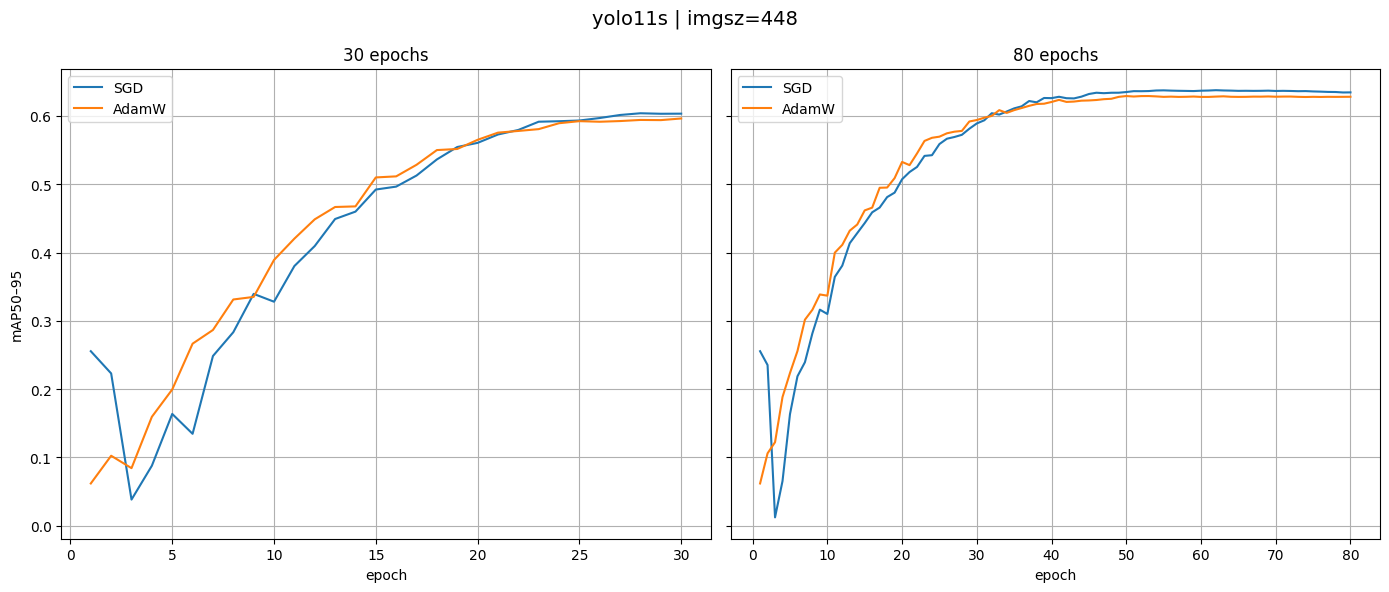

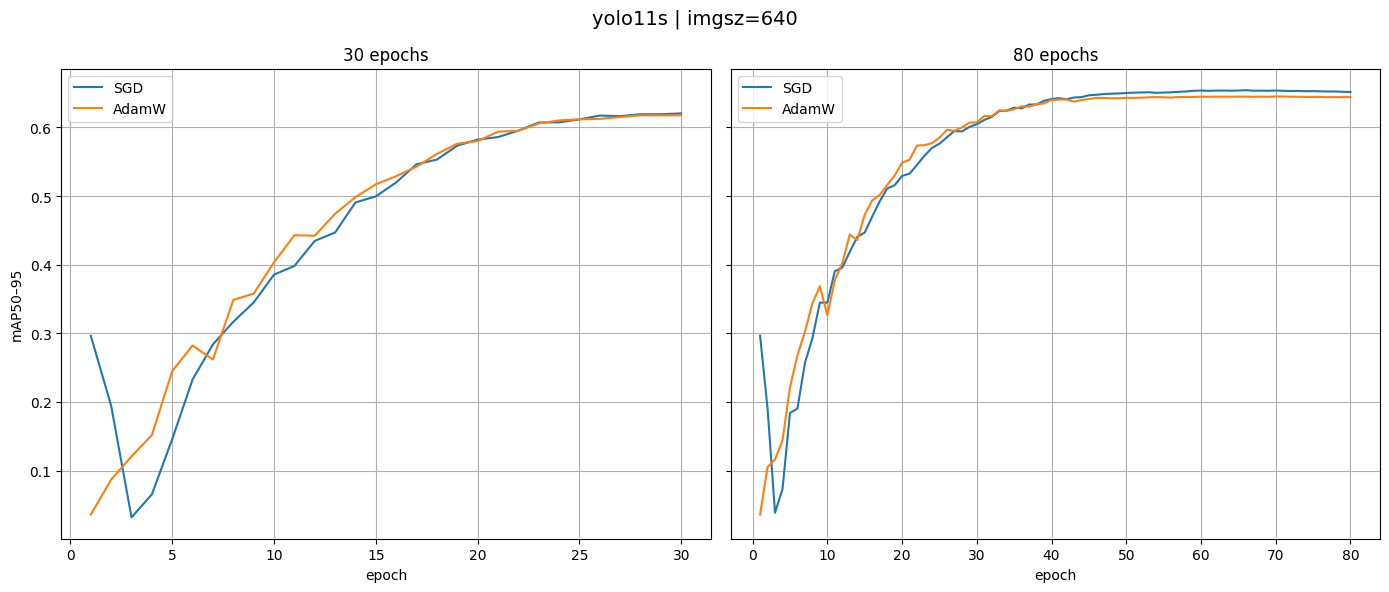

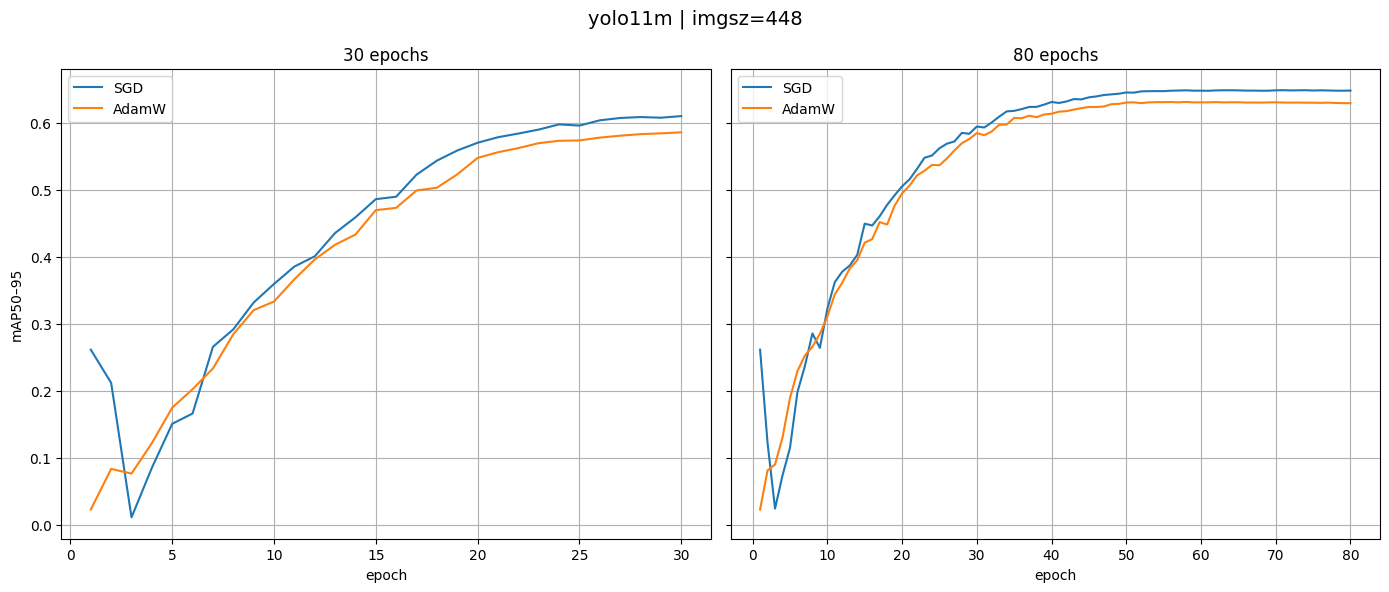

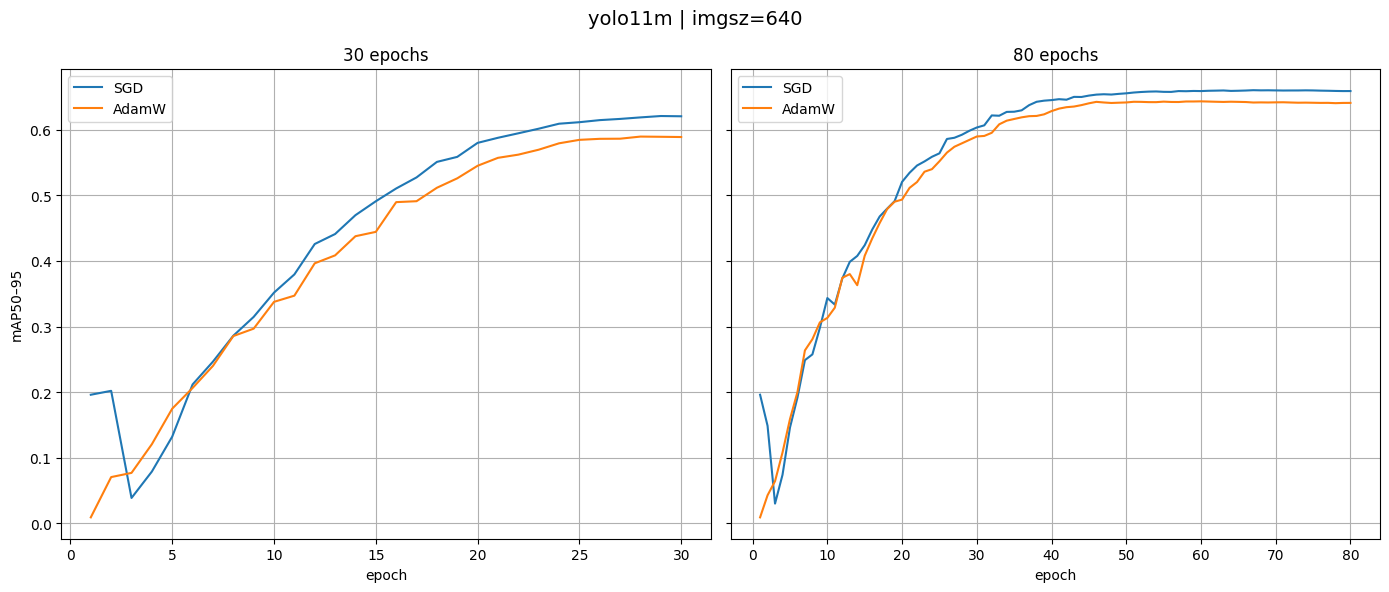

In [27]:
def plot_map_by_epochs(base_model, imgsz):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for ax, epochs in zip(axes, epochs_list):
        paths = {
            "SGD": (
                Path(f"runs/{base_model}")
                / f"epochs{epochs}_imgsz{imgsz}_SGD"
                / "results.csv"
            ),
            "AdamW": (
                Path(f"runs/{base_model}")
                / f"epochs{epochs}_imgsz{imgsz}_AdamW"
                / "results.csv"
            )
        }

        for opt, path in paths.items():
            if not path.exists():
                continue
            df = pd.read_csv(path)
            ax.plot(df["epoch"], df["metrics/mAP50-95(B)"], label=opt)

        ax.set_title(f"{epochs} epochs")
        ax.set_xlabel("epoch")
        ax.grid(True)
        ax.legend()

    axes[0].set_ylabel("mAP50–95")
    fig.suptitle(f"{base_model} | imgsz={imgsz}", fontsize=14)
    plt.tight_layout()
    plt.show()


for base_model in BASE_MODELS:
    for imgsz in imgsz_list:
        plot_map_by_epochs(base_model, imgsz)

Với cùng một tổ hợp tham số nhưng nếu `epochs` cao hơn (80 so với 30) thì chỉ số `mAP50-95` được cải thiện.

Các biểu đồ cho thấy `AdamW` thường đạt `mAP50–95` cao hơn trong các `epoch` đầu. Tuy nhiên, ở các `epoch` sau, chỉ số `map50-95` của optimizer `SGD` có cải thiện và trong đa số trường hợp đạt `mAP50–95` tương đương hoặc cao hơn `AdamW`.

`AdamW` thường hội tụ nhanh hơn `SGD`, trong khi `SGD` ít biến động hơn khi huấn luyện mô hình trong thời gian dài, cho phép quá trình tối ưu diễn ra ổn định và hiệu quả hơn.

Ngoài ra, mô hình gốc cũng tác động đến chỉ số này. Ở hai biểu đồ đầu tiên, khi mô hình gốc là YOLO11s, có thể thấy đường chỉ số `mAP50-95` của cả hai optimizer đều gần như trùng nhau hoặc cách nhau một đoạn rất ngắn, tức là chỉ số `mAP50-95` gần bằng nhau; còn với YOLO11m, khi mô hình được huấn luyện đến những `epoch` cuối, chỉ số `mAP50-95` cách nhau một đoạn khá xa, có sự khác biệt rõ rệt hơn so với YOLO11s.

Ở những biểu đồ thể hiện kết quả mô hình được huấn luyện với 80 `epochs`, từ `epoch` 30 trở đi thì `SGD` tỏ ra ưu thế hơn so với `AdamW`, khi đường `mAP50-95` của cả hai optimizer đều cắt nhau trong khoảng `epoch` 10 đến 20.

### Ảnh hưởng của imgsz (mAP50–95 theo imgsz, chọn 80 epochs)

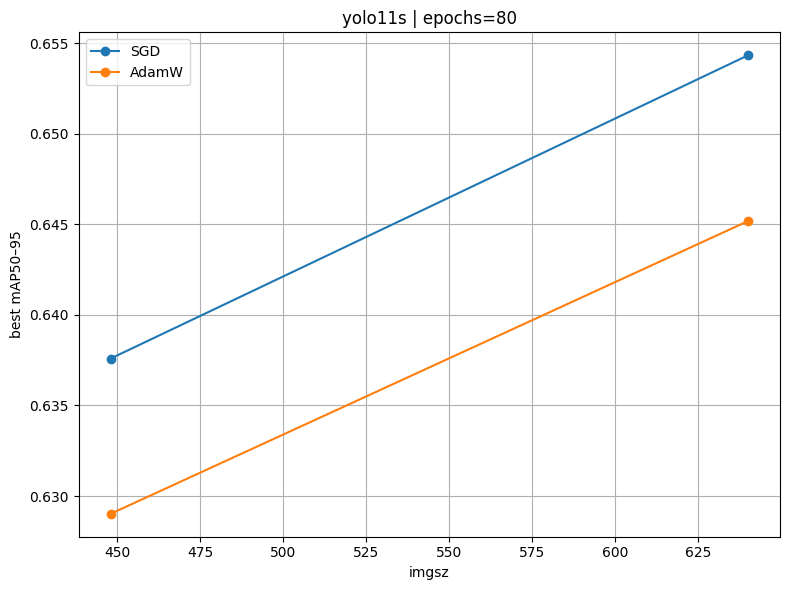

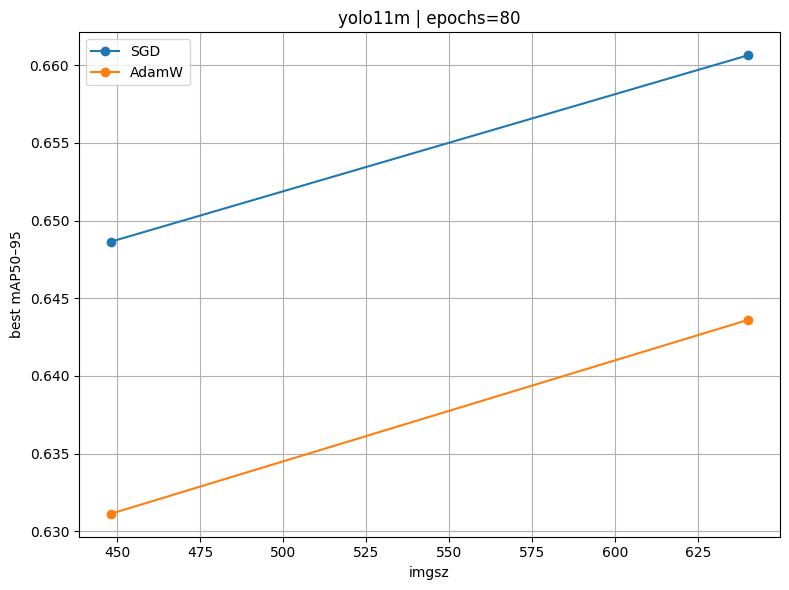

In [28]:
def plot_map_by_imgsz(base_model, epochs):
    plt.figure(figsize=(8, 6))

    for optimizer in ["SGD", "AdamW"]:
        maps = []

        for imgsz in imgsz_list:
            path = (
                Path(f"runs/{base_model}")
                / f"epochs{epochs}_imgsz{imgsz}_{optimizer}"
                / "results.csv"
            )
            if not path.exists():
                maps.append(None)
                continue

            df = pd.read_csv(path)
            maps.append(df["metrics/mAP50-95(B)"].max())

        plt.plot(imgsz_list, maps, marker="o", label=optimizer)

    plt.xlabel("imgsz")
    plt.ylabel("best mAP50–95")
    plt.title(f"{base_model} | epochs={epochs}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


for base_model in BASE_MODELS:
    plot_map_by_imgsz(base_model, epochs=80)


Khi so sánh cố định `mAP50-95` theo `imgsz`, cần lấy kết quả `mAP50-95` cao nhất để so sánh.

Các biểu đồ cho `SGD` cho kết quả vượt trội hơn hẳn so với `AdamW`. Khi cố định số `epochs`, việc tăng `imgsz` từ 448 lên 640 giúp cải thiện `mAP50–95` trong các trường hợp, đặc biệt rõ rệt khi sử dụng SGD ở 80 epochs. `imgsz` cao cũng có ích trong việc phát hiện và nhận diện object nhỏ. Tuy nhiên, khi tăng `imgsz`, do có chi tiết cao nên cần nhiều thời gian và tài nguyên tính toán hơn so với `imgsz` nhỏ.

## KẾT QUẢ TỐT NHẤT (TÍNH THEO mAP50-95)

Nếu dựa vào giá trị `mAP50-95` tốt nhất để xem thử mô hình nào là tốt nhất thì đó chính là YOLO11m với optimizer `SGD`, `epochs=`80 và `imgsz=640`. Tuy nhiên, không phải cứ `mAP50-95` cao thì mô hình gọi là tốt, cần phải tối ưu giữa giá trị này và yêu cầu thực tế của vấn đề, cân bằng với thời gian và chi phí tính toán,...

In [29]:
best_results = (
    last_results
    .sort_values("mAP50-95", ascending=False, ignore_index=True)
    .groupby("model", as_index=False)
    .head(1)
)

best_results

,model,optimizer,epochs,best_epoch,imgsz,mAP50,mAP50-95,precision,recall
0,yolo11m,SGD,80,67,640,0.79857,0.66064,0.79258,0.75042
1,yolo11s,SGD,80,66,640,0.79853,0.65433,0.80859,0.74059


# ƯU VÀ NHƯỢC ĐIỂM CỦA YOLO

## ƯU ĐIỂM

- **Tính ổn định và khả năng hội tụ tốt**: Kết quả thực nghiệm cho thấy mô hình YOLO11 hoạt động ổn định khi sử dụng thuật toán tối ưu `SGD` với momentum. So với `AdamW` thì `SGD` đạt `mAP50–95` cao hơn khi huấn luyện dài (80 `epochs`), mặc dù `AdamW` hội tụ nhanh hơn so với `SGD.
- **Hiệu quả tài nguyên vượt trội**: Bên cạnh mô hình tốt nhất là YOLO11m thi kết quả của YOLO11s cũng rất nổi bật. Mặc dù có số lượng tham số ít hơn và yêu cầu tài nguyên tính toán thấp hơn đáng kể, nhưng chỉ số `mAP50-95` của YOLO11s đạt 0.65433, chỉ kém YOLO11m (đạt 0.66064) một khoảng rất nhỏ (0.95513%, chưa đến 1%). Điều này chứng tỏ kiến trúc của YOLO11 được tối ưu tốt, phù hợp cho triển khai trên các thiết bị biên có tài nguyên hạn chế.
- **Độ tin cậy cao trong quyết định phân loại**: Dựa trên bảng chỉ số đánh giá, mô hình đạt được mức `precision` lên tới 80.86% (đối với YOLO11s, `imgsz` 640px và 80 `epochs`), cao hơn đáng kể so với chỉ số `recall`. Điều này đặc biệt quan trọng trong các bài toán ứng dụng thực tế như giám sát an ninh, nơi độ tin cậy của mỗi cảnh báo đóng vai trò then chốt. Nghĩa là khi hệ thống đưa ra cảnh báo "có người" hoặc "có động vật", độ tin cậy của cảnh báo đó là rất cao. Việc hạn chế các báo động giả (báo nhầm vật thể tĩnh thành động vật/người) giúp hệ thống trở nên đáng tin cậy hơn trong mắt người dùng cuối, tránh gây phiền toái hoặc lãng phí tài nguyên kiểm tra lại.
- **Khả năng ứng dụng thời gian thực**: Mô hình YOLO11 có thể cân bằng giữa tốc độ và độ chính xác. Cơ chế "You Only Look Once" cho phép mô hình xử lý toàn bộ bức ảnh trong một lần lan truyền mạng, giúp tốc độ suy luận rất nhanh, phù hợp với các bài toán thời gian thực. Bên cạnh đó, việc tăng kích thước ảnh đầu vào lên 640px giúp cải thiện rõ rệt khả năng phát hiện các đối tượng nhỏ và phức tạp, thể hiện khả năng học đa quy mô hiệu quả.

## HẠN CHẾ

Dự án bộc lộ những hạn chế xuất phát từ đặc điểm dữ liệu. Thách thức lớn nhất là sự mất cân bằng dữ liệu nghiêm trọng (data imbalance), với sự chênh lệch quá lớn về số object của các class (7 class có nhiều object nhất đều có trên 1000 ngàn và 15 class có ít object nhất có dưới 400 object). Điều này dẫn đến việc mô hình có xu hướng thiên kiến (bias), nhận diện rất tốt các class phổ biến nhưng lại có `recall` thấp đối với các class thiểu số. Ngoài ra, dù đã sử dụng kích thước ảnh là 640px, mô hình vẫn gặp khó khăn nhất định khi các đối tượng bị che khuất một phần hoặc nằm chồng chéo lên nhau với mật độ dày đặc.

# ỨNG DỤNG

- **Trong giám sát an ninh**: Mô hình có thể được tích hợp vào camera giám sát để tự động phát hiện sự xâm nhập của con người vào các khu vực cấm hoặc phát hiện động vật hoang dã đi lạc vào khu dân cư, giúp cảnh báo sớm các nguy cơ.
- **Trong bảo tồn thiên nhiên**: Ứng dụng vào các hệ thống "bẫy ảnh" (camera traps) để tự động đếm, phân loại và theo dõi hành vi của động vật hoang dã trong rừng mà không cần sự can thiệp thủ công của con người, giúp tiết kiệm thời gian phân tích dữ liệu khổng lồ.
- **Trong nông nghiệp thông minh**: Hỗ trợ giám sát, đếm số vật nuôi trong đàn, phát hiện vật nuôi đi lạc hoặc theo dõi sức khỏe vật nuôi thông qua tần suất xuất hiện và hành vi vận động.
- **Trong sản xuất**: Đếm số lượng sản phẩm, số nông sản,... trên băng chuyền nhà máy.

# KẾT LUẬN

Dự án đã hoàn thành mục tiêu xây dựng hệ thống nhận diện đối tượng dựa trên nền tảng deep learing, giải quyết hiệu quả bài toán phân loại con người và động vật, áp dụng các quy trình từ tìm kiếm, làm sạch, chuẩn hóa, phân tích dữ liệu, phân tích khám phá (EDA) để nhận diện các điểm mù thông tin, đến việc huấn luyện mô hình với nhiều tham số khác nhau để tìm ra kết quả tốt nhất.

Tuy nhiên, thách thức về mất cân bằng dữ liệu (data imbalance) vẫn tạo ra rào cản nhất định đối với hiệu năng của các class thiểu số, nhưng kết quả `mAP50-95` đạt xấp xỉ 0.65-0.66 vẫn tương đối tốt. Đây là tiền đề vững chắc để mở ra các hướng nghiên cứu tiếp theo, tập trung vào các giải pháp như tăng cường dữ liệu (data augmentation) hay tái lấy mẫu (oversampling) nhằm cân bằng lại phân phối object của các class, hướng tới mục tiêu xây dựng một hệ thống hoàn thiện, chính xác và có khả năng ứng dụng thực tiễn cao hơn.

# TÀI LIỆU THAM KHẢO

- Các tài liệu, bài giảng môn Python cho khoa học dữ liệu, ThS. Hà Văn Thảo, Trường Đại học Khoa học Tự nhiên, ĐHQG-HCM.
- Trang guide của Ultralytics: https://docs.ultralytics.com/guides/
- Các tài liệu khác liên quan đến Python và nhận diện hình ảnh.